In [6]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from scipy.stats import t

In [7]:
# Function to extract epoch from the first few rows of the CSV file
def extract_epoch_from_header(file):
    # Read the first few lines to find the epoch (assuming it's in a comment or a header)
    with open(file, 'r') as f:
        skiprow = f.readline()
        skiprow = skiprow.strip().split()[0]
        for line in f:
            if "startdate:" in line.lower():  # Assuming the word 'epoch' is present in the line
                # Extract the epoch date (this assumes the date is the second item in the line)
                epoch = line.strip().split()[1]
                return int(skiprow)-1, epoch[0:4]+"-"+epoch[4:6]+"-"+epoch[6:8]+" "+epoch[8:10]+":"+epoch[10:12]+":"+epoch[12:14]
    return None  # Return None if no epoch is found

# Function to load and adjust time for each CSV
def load_and_adjust_time(file):
    # Try to extract the epoch from the header or a specific column
    nskiprows,epoch = extract_epoch_from_header(file)
   
    if epoch is None:
        raise ValueError(f"Could not find epoch for file: {file}")
   
    # Load the actual data (skipping header if necessary)
    df = pd.read_csv(file, skiprows=nskiprows,sep="\\s+")  # Adjust skiprows based on where the data starts
   
    # Convert 'time' column to a datetime, assuming it's in days
    # Adjust time column to start from the epoch time found in the file
    df['starttime_dt'] = pd.to_timedelta(df['starttime'], unit='D') + pd.Timestamp(epoch)
   
    # Return the adjusted DataFrame
    return df

In [8]:

# Path to the text file
file_path1 =  r"C:\\YEAR1\\NMVOC\\Data\\data_CO_CH4\\co_cmn_surface-insitu_74_2008_2017_event.txt"
file_path2 =  r"C:\\YEAR1\\NMVOC\\Data\\data_CO_CH4\\ICOS_ATC_L2_L2-2024.1_CMN_8.0_CTS.CO"



CO_17 = pd.read_csv(file_path1,sep=" ",skiprows=174)
CO_24 = pd.read_csv(file_path2, sep=";",skiprows=44)


In [9]:
#unit ppb
CO_17['datetime'] = pd.to_datetime(CO_17[['year', 'month', 'day', 'hour']])
CO_17 = CO_17[CO_17['QCflag'] != 3]  # Filter rows where 'QCflag:comment' equals 3
CO_17 = CO_17[CO_17['QCflag']!= -999.999] 
CO_17 = CO_17[CO_17['QCflag']!= -9] 
CO_17 = CO_17[CO_17['year']!= 2008] 
CO_17 = CO_17[CO_17['year']!= 2009] 
CO_17 = CO_17[CO_17['year']!= 2010] 
CO_17 = CO_17.drop(columns=["nvalue"]) 
CO_17 = CO_17.drop(columns=["value_unc"]) 
CO_17 = CO_17.drop(columns=["second"])
CO_17 = CO_17.drop(columns=["year.1"])
CO_17 = CO_17.drop(columns=["month.1"])
CO_17 = CO_17.drop(columns=["day.1"])
CO_17 = CO_17.drop(columns=["hour.1"])
CO_17 = CO_17.drop(columns=["minute.1"])
CO_17 = CO_17.drop(columns=["second.1"])
CO_17 = CO_17.drop(columns=["longitude"])
CO_17 = CO_17.drop(columns=["altitude"])
CO_17 = CO_17.drop(columns=["elevation"])
CO_17 = CO_17.drop(columns=["site_gaw_id"])
CO_17 = CO_17.drop(columns=["latitude"])
CO_17 = CO_17.drop(columns=["intake_height"])
CO_17 = CO_17.drop(columns=["flask_no"])
CO_17 = CO_17.drop(columns=["ORG_QCflag"])
CO_17 = CO_17.drop(columns=["QCflag"])
CO_17 = CO_17.drop(columns=["instrument"])
CO_17 = CO_17.drop(columns=["measurement_method"])
CO_17 = CO_17.drop(columns=["scale"])
CO_17 = CO_17.drop(columns=["minute"])
CO_17.rename(columns={ "value":"co"},inplace=True)
CO_17

,year,month,day,hour,co,datetime
44999,2011,2,25,16,181.351,2011-02-25 16:00:00
45000,2011,2,25,17,198.561,2011-02-25 17:00:00
45001,2011,2,25,17,203.914,2011-02-25 17:00:00
45002,2011,2,25,18,193.812,2011-02-25 18:00:00
45003,2011,2,25,18,158.143,2011-02-25 18:00:00
...,...,...,...,...,...,...
139761,2017,12,27,5,94.160,2017-12-27 05:00:00
139762,2017,12,27,5,95.069,2017-12-27 05:00:00
139763,2017,12,27,5,96.678,2017-12-27 05:00:00
139764,2017,12,27,6,99.394,2017-12-27 06:00:00


In [10]:
#loop for rounding to the hours
CO_17["datetime"] = [i.round("h") for i in CO_17["datetime"]]
#CO_17.index = CO_17["datetime"]
CO_17 = CO_17.drop(columns=["year"])
CO_17 = CO_17.drop(columns=["month"])
CO_17 = CO_17.drop(columns=["day"])
CO_17 = CO_17.drop(columns=["hour"])
CO_17

,co,datetime
44999,181.351,2011-02-25 16:00:00
45000,198.561,2011-02-25 17:00:00
45001,203.914,2011-02-25 17:00:00
45002,193.812,2011-02-25 18:00:00
45003,158.143,2011-02-25 18:00:00
...,...,...
139761,94.160,2017-12-27 05:00:00
139762,95.069,2017-12-27 05:00:00
139763,96.678,2017-12-27 05:00:00
139764,99.394,2017-12-27 06:00:00


In [11]:
#unit nmol.mol-¹
CO_24['datetime'] = pd.to_datetime(CO_24[['Year', 'Month', 'Day', 'Hour']])
CO_24 = CO_24[CO_24['Flag'] != "N"]  # Filter rows where 'QCflag:comment' equals 3
CO_24 = CO_24[CO_24['Flag']!= "K"] 
CO_24 = CO_24[CO_24['co']!= -9] 
CO_24 = CO_24.drop(columns=["Flag"]) 
CO_24 = CO_24.drop(columns=["Site"]) 
CO_24 = CO_24.drop(columns=["SamplingHeight"]) 
CO_24 = CO_24.drop(columns=["DecimalDate"]) 
CO_24 = CO_24.drop(columns=["NbPoints"]) 
CO_24 = CO_24.drop(columns=["InstrumentId"])
CO_24 = CO_24.drop(columns=["QualityId"])                            
CO_24 = CO_24.drop(columns=["LTR"])     
CO_24 = CO_24.drop(columns=["CMR"])                              
CO_24 = CO_24.drop(columns=["STTB"])    
CO_24 = CO_24.drop(columns=["QcBias"])  
CO_24 = CO_24.drop(columns=["QcBiasUncertainty"])                              
CO_24 = CO_24.drop(columns=["co-WithoutSpikes"]) 
CO_24 = CO_24.drop(columns=["Stdev-WithoutSpikes"]) 
CO_24 = CO_24.drop(columns=["NbPoints-WithoutSpikes"]) 
CO_24 = CO_24.drop(columns=["Stdev"]) 
CO_24 = CO_24.drop(columns=["Minute"]) 
CO_24

,Year,Month,Day,Hour,co,datetime
168,2018,5,10,0,125.967,2018-05-10 00:00:00
169,2018,5,10,1,124.368,2018-05-10 01:00:00
170,2018,5,10,2,119.503,2018-05-10 02:00:00
171,2018,5,10,3,117.950,2018-05-10 03:00:00
172,2018,5,10,4,121.115,2018-05-10 04:00:00
...,...,...,...,...,...,...
51835,2024,3,31,19,120.041,2024-03-31 19:00:00
51836,2024,3,31,20,119.126,2024-03-31 20:00:00
51837,2024,3,31,21,117.875,2024-03-31 21:00:00
51838,2024,3,31,22,117.212,2024-03-31 22:00:00


In [12]:
#loop for rounding to the hours
CO_24["datetime"] = [i.round("h") for i in CO_24["datetime"]]
#CO_24.index = CO_24["datetime"]
CO_24 = CO_24.drop(columns=["Year"])
CO_24 = CO_24.drop(columns=["Month"])
CO_24 = CO_24.drop(columns=["Day"])
CO_24 = CO_24.drop(columns=["Hour"])
CO_24

,co,datetime
168,125.967,2018-05-10 00:00:00
169,124.368,2018-05-10 01:00:00
170,119.503,2018-05-10 02:00:00
171,117.950,2018-05-10 03:00:00
172,121.115,2018-05-10 04:00:00
...,...,...
51835,120.041,2024-03-31 19:00:00
51836,119.126,2024-03-31 20:00:00
51837,117.875,2024-03-31 21:00:00
51838,117.212,2024-03-31 22:00:00


In [13]:
co_df = pd.concat([CO_17, CO_24]).sort_values('datetime').reset_index(drop=True)

In [14]:
co_df.index = co_df["datetime"]
# Resample data hourly and calculate the mean
co_hourly_means = co_df.resample('h').mean()
#remove lines with NaN
co_hourly_means.dropna(how='any', inplace=True)
co_hourly_means['CO_ppb']=co_hourly_means['co']
co_hourly_means = co_hourly_means.drop(columns=["co"])
co_hourly_means


,datetime,CO_ppb
datetime,,
2011-02-25 16:00:00,2011-02-25 16:00:00,181.3510
2011-02-25 17:00:00,2011-02-25 17:00:00,201.2375
2011-02-25 18:00:00,2011-02-25 18:00:00,175.9775
2011-02-25 19:00:00,2011-02-25 19:00:00,156.8525
2011-02-25 22:00:00,2011-02-25 22:00:00,166.7825
...,...,...
2024-03-31 19:00:00,2024-03-31 19:00:00,120.0410
2024-03-31 20:00:00,2024-03-31 20:00:00,119.1260
2024-03-31 21:00:00,2024-03-31 21:00:00,117.8750


In [15]:
# Reset index and reformat DataFrame

co_hourly_means = co_hourly_means.drop(columns=["datetime"])
co_hourly_means.head()

,CO_ppb
datetime,
2011-02-25 16:00:00,181.3510
2011-02-25 17:00:00,201.2375
2011-02-25 18:00:00,175.9775
2011-02-25 19:00:00,156.8525
2011-02-25 22:00:00,166.7825


In [16]:
save_dir="C:\\YEAR1\\NMVOC\\Data\\" 

# Save final  DataFrame
output_file = os.path.join(save_dir, "processed_CO.csv")
co_hourly_means.to_csv(output_file, index=True)

print(f"Saved final data to: {output_file}")

Saved final data to: C:\YEAR1\NMVOC\Data\processed_CO.csv


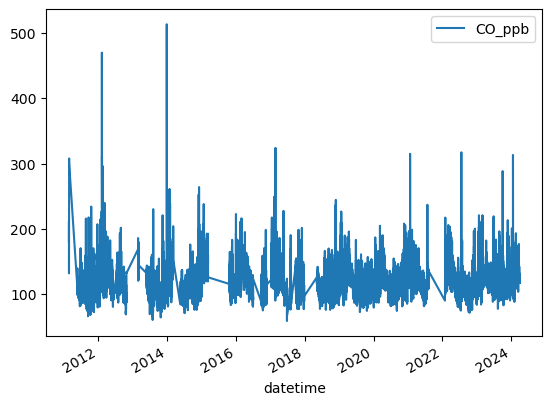

In [17]:
co_hourly_means.plot()

plt.show()